In [ ]:
pip install optuna

In [ ]:
pip install torch-summary

In [2]:
import warnings

import os
import time
import copy
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.transforms.v2 as T
import torchvision.transforms as tt
#import optuna
import torch.optim as optim

#from optuna.trial import TrialState
from IPython.display import clear_output
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from torchvision import datasets, models, transforms
from sklearn.metrics import roc_auc_score
from torch.utils.data import ConcatDataset
import torchvision
from sklearn import metrics
#from torchsummary import summary
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision.models as models
from torch.utils.data import Dataset, random_split
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from IPython.display import clear_output

warnings.filterwarnings('ignore')

In [3]:
import torch
import random
#from torchsummary import summary

In [4]:
seede = 11
random.seed(seede)
np.random.seed(seede)
torch.manual_seed(seede)
torch.cuda.manual_seed(seede)

### *Downloading data*

In [5]:
all_xray_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/kaggle', 'input','data', 'images*', 'images', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.index = all_xray_df['Image Index']
all_xray_df.drop('Image Index',axis=1,inplace = True)
all_xray_df.head(3)

Scans found: 112120 , Total Headers 112120


,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
Image Index,,,,,,,,,,,,
00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/kaggle/input/data/images_001/images/00000001_...
00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/kaggle/input/data/images_001/images/00000001_...
00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/kaggle/input/data/images_001/images/00000001_...


In [6]:
test_names = pd.read_csv("/kaggle/input/file-split-names/test_list (1).txt",sep=' ',header=None)
train_names = pd.read_csv("/kaggle/input/file-split-names/train_list.txt",sep=' ',header=None)
val_names = pd.read_csv("/kaggle/input/file-split-names/val_list.txt",sep=' ',header=None)

#### Take 85% of data (if don't have enough resourses)

In [ ]:
k = [i for i in range(78468)]
r = [i for i in range(11219)]
m = [i for i in range(22433)]
np.random.shuffle(k)
np.random.shuffle(r)
np.random.shuffle(m)
train_names_fewer = train_names.iloc[k[:int(78468*0.85)]]
test_names_fewer = test_names.iloc[m[:int(22433*0.85)]]
val_names_fewer = val_names.iloc[r[:int(11219*0.85)]]

In [ ]:
test_names_fewer['path'] = all_xray_df['path'][test_names_fewer[0].values].values
val_names_fewer['path'] = all_xray_df['path'][val_names_fewer[0].values].values
train_names_fewer['path'] = all_xray_df['path'][train_names_fewer[0].values].values

In [ ]:
train_names_fewer.drop(0,axis=1,inplace=True)
test_names_fewer.drop(0,axis=1,inplace=True)
val_names_fewer.drop(0,axis=1,inplace=True)

In [ ]:
train_names_fewer.reset_index(inplace=True)
test_names_fewer.reset_index(inplace=True)
val_names_fewer.reset_index(inplace=True)

### **Full dataset**

In [7]:
test_names['path'] = all_xray_df['path'][test_names[0].values].values
val_names['path'] = all_xray_df['path'][val_names[0].values].values
train_names['path'] = all_xray_df['path'][train_names[0].values].values

In [8]:
train_names.drop(0,axis=1,inplace=True)
test_names.drop(0,axis=1,inplace=True)
val_names.drop(0,axis=1,inplace=True)

In [9]:
class ChestXray14Dataset(Dataset):
    SPLIT_RANDOM_SEED = 11

    def __init__(self,data,transform=None):
        super().__init__()
        self.data = data['path']
        self.labels = (data[[i for i in range(1,15)]].values).astype(float)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        image_name = self.data[item]
        image = Image.open(image_name).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, self.labels[item]

In [10]:
transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

**85% of data**

In [ ]:
train_dataset = ChestXray14Dataset(train_names_fewer,transform)
val_dataset = ChestXray14Dataset(val_names_fewer,transform)
test_dataset = ChestXray14Dataset(test_names_fewer,transform)

**Full dataset**

In [11]:
train_dataset = ChestXray14Dataset(train_names,transform)
val_dataset = ChestXray14Dataset(val_names,transform)
test_dataset = ChestXray14Dataset(test_names,transform)

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=32, pin_memory=True, num_workers=11)
val_dataloader = DataLoader(val_dataset, batch_size=32, pin_memory=True, num_workers=11)
test_dataloader = DataLoader(test_dataset, batch_size=32, pin_memory=True, num_workers=11)

In [13]:
if torch.cuda.is_available():
    device=torch.device("cuda")
    print("Training on GPU")
else:
    device = torch.device("cpu")
    print("Training on CPU")

Training on GPU


### *Training method*

In [14]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

hm... doesn't work(

In [15]:
def calc_loss(inputs,labels):
    pos = (labels>0).sum().item()
    neg = labels.shape[0]*labels.shape[1]-pos
    weigh_p = (pos+neg)/pos if pos!=0 else 0
    weight_n = (pos+neg)/neg if neg!=0 else 0
    loss = -1*(weigh_p*torch.sum(torch.log(inputs[labels>0])) + weight_n*torch.sum(torch.log(1-inputs[labels==0])))
    return loss

In [48]:
def accuracy(inputs, labels):
    temp = 0
    inp = nn.Sigmoid()(inputs)
    for i in range(labels.shape[0]):
        pred = inp[i]>0.5
        k = torch.sum(torch.logical_or(labels[i], pred))
        if k!=0:
            temp += (torch.sum(torch.logical_and(labels[i], pred)) / k).item()
    return temp

In [20]:
def training_epoch(model, scheduler, optimizer, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes\
        
        pos = (labels>0).sum().item()
        neg = labels.shape[0]*labels.shape[1]-pos
        w_pos = neg/pos if pos!=0 else 0
        weights = torch.full((14,),w_pos)
        weights = labels.to(device)
        
        criterion = nn.BCEWithLogitsLoss(pos_weight = weights)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.shape[0]
        train_accuracy += accuracy(logits, labels)
        
        #torch.cuda.empty_cache()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy

In [21]:
@torch.no_grad()
def validation_epoch(model, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        
        pos = (labels>0).sum().item()
        neg = labels.shape[0]*labels.shape[1]-pos
        w_pos = neg/pos if pos!=0 else 0
        weights = torch.full((14,),w_pos)
        weights = labels.to(device)
        
        criterion = nn.BCEWithLogitsLoss(pos_weight = weights)
        loss = criterion(logits, labels)
        
        test_loss += loss.item() * images.shape[0]
        test_accuracy += accuracy(logits, labels)

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy


In [22]:
def train(model, optimizer, scheduler, train_loader, test_loader, num_epochs):
    since = time.time()
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    best_acc = np.NINF

    #for ResNet50 CRIT IN PARAMS

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, scheduler, optimizer, train_loader,    #For Resnet50 - crit
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()  # if ReduceLROnPlateau - scheduler.step(test_loss)

        if test_loss < best_loss:
            best_loss = test_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        if test_accuracy > best_acc:
            best_acc = test_accuracy

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        #plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)
        print(f'Epoch {epoch}: training_loss = {train_loss}, train_acc = {train_accuracy}\n             val_loss = {test_loss}, val_acc = {test_accuracy}')
        torch.save(model.state_dict(), f'Epoch_{epoch}.pt') # save epoch params
        
    
    model.load_state_dict(best_model_wts)
    time_since = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))
    print('Best val acc: {:.4f}'.format(best_acc))
    results = pd.DataFrame({'train_loss':train_losses,'train_acc':train_accuracies,'test_loss':test_losses,'test_acc':test_accuracies})
    results.to_csv('results_of_training_Chest_Xray14.csv',index = False)

    # Now we'll load in the best model weights and return it
    return model

### Baseline Net

In [23]:
class ChestXrayNet(nn.Module):
    def __init__(self, image_channels=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=32, padding='same', kernel_size=3),  #  32 x 1024 x 1024
            nn.ReLU(),
            nn.MaxPool2d(2),  #  32 x 512 x 512
            nn.Dropout(0.2),

            nn.Conv2d(in_channels = 32, out_channels=64, padding='same', kernel_size=3),  #  64 x 512 x 512
            nn.ReLU(),
            nn.MaxPool2d(2),  #  64 x 256 x 256
            nn.Dropout(0.1),

            nn.Conv2d(in_channels = 64, out_channels=128, padding='same', kernel_size=3),  #  128 x 256 x 256
            nn.ReLU(),
            nn.MaxPool2d(2),  #  128 x 128 x 128
            nn.Dropout(0.3),

            nn.Conv2d(in_channels = 128, out_channels=256, padding='same', kernel_size=3),  #  256 x 128 x 128
            nn.ReLU(),
            nn.MaxPool2d(2),  #  256 x 64 x 64
            nn.Dropout(0.2),

            nn.Conv2d(in_channels = 256, out_channels=256, stride=2, kernel_size=2),  #  256 x 32 x 32
            nn.ReLU(),
            nn.MaxPool2d(2),  #  256 x 16 x 16
            nn.Dropout(0.2),

            nn.Conv2d(in_channels = 256, out_channels=512, padding='same', kernel_size=3),  #  512 x 16 x 16
            nn.ReLU(),
            nn.MaxPool2d(2),  #  512 x 8 x 8
            nn.Dropout(0.2),
            
            nn.Conv2d(in_channels = 512, out_channels=512, stride=2, kernel_size=2),  # 512 4 x 4
            nn.ReLU(),
            nn.MaxPool2d(2),  #  512 x 2 x 2
            nn.Dropout(0.2),

            nn.Flatten()  # 2048
        )

        self.head = nn.Sequential(
            nn.Linear(in_features=2048 , out_features=256),
            nn.ReLU(),
            nn.Linear(in_features = 256, out_features=14),
            #nn.Sigmoid()
        )

    def forward(self, x):
        out = self.encoder(x)
        out = self.head(out)
        return out

In [61]:
num_epoch = 12
model = ChestXrayNet().cuda()
model = torch.nn.DataParallel(model).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epoch)

In [25]:
base_model = train(model, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs=num_epoch)
torch.save(base_model.state_dict(), 'chest_X14model.pt')

Training 1/12:   0%|          | 0/2453 [00:00<?, ?it/s]

Validating 1/12:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 1: training_loss = 0.18647253785992368, train_acc = 2.973611526073116e-05
             val_loss = 0.1773526773264472, val_acc = 0.0


Training 2/12:   0%|          | 0/2453 [00:00<?, ?it/s]

Validating 2/12:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 2: training_loss = 0.18009677426444562, train_acc = 0.0
             val_loss = 0.1745594055036968, val_acc = 0.0


Training 3/12:   0%|          | 0/2453 [00:00<?, ?it/s]

Validating 3/12:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 3: training_loss = 0.1780494295038676, train_acc = 0.0
             val_loss = 0.17324260442452108, val_acc = 0.0


Training 4/12:   0%|          | 0/2453 [00:00<?, ?it/s]

Validating 4/12:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 4: training_loss = 0.17692479130434588, train_acc = 0.0
             val_loss = 0.17216341068502766, val_acc = 0.0


Training 5/12:   0%|          | 0/2453 [00:00<?, ?it/s]

Validating 5/12:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 5: training_loss = 0.1753486250861462, train_acc = 0.0
             val_loss = 0.17084015072511166, val_acc = 0.0


Training 6/12:   0%|          | 0/2453 [00:00<?, ?it/s]

Validating 6/12:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 6: training_loss = 0.17390796933675987, train_acc = 0.0
             val_loss = 0.17014494400685914, val_acc = 0.0


Training 7/12:   0%|          | 0/2453 [00:00<?, ?it/s]

Validating 7/12:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 7: training_loss = 0.1727355272486644, train_acc = 0.0
             val_loss = 0.1694129934332851, val_acc = 0.0


Training 8/12:   0%|          | 0/2453 [00:00<?, ?it/s]

Validating 8/12:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 8: training_loss = 0.17157892158911361, train_acc = 0.0
             val_loss = 0.16878668303659508, val_acc = 0.0


Training 9/12:   0%|          | 0/2453 [00:00<?, ?it/s]

Validating 9/12:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 9: training_loss = 0.17034506820555942, train_acc = 0.0
             val_loss = 0.1680683214604739, val_acc = 0.0


Training 10/12:   0%|          | 0/2453 [00:00<?, ?it/s]

Validating 10/12:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 10: training_loss = 0.16942836878193193, train_acc = 1.6992064832383148e-05
             val_loss = 0.16758268777101112, val_acc = 0.0


Training 11/12:   0%|          | 0/2453 [00:00<?, ?it/s]

Validating 11/12:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 11: training_loss = 0.1686986122148148, train_acc = 1.27440485293368e-05
             val_loss = 0.16724966871518313, val_acc = 0.0


Training 12/12:   0%|          | 0/2453 [00:00<?, ?it/s]

Validating 12/12:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 12: training_loss = 0.16809933981926206, train_acc = 3.1860121323342e-05
             val_loss = 0.16717427861806766, val_acc = 0.0
Training complete in 368m 21s
Best val loss: 0.1672
Best val acc: 0.0000


In [ ]:
more_train_model = train(base_model, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs=num_epoch)
torch.save(more_train_model.state_dict(), 'more_train_chest_X14model.pt')

Training 1/5:   0%|          | 0/2453 [00:00<?, ?it/s]

Validating 1/5:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 1: training_loss = 0.172176183596757, train_acc = 0.0011417757237976028
             val_loss = 0.16839206421814293, val_acc = 0.0015672817035987528


Training 2/5:   0%|          | 0/2453 [00:00<?, ?it/s]

Validating 2/5:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 2: training_loss = 0.17108733942547985, train_acc = 0.0017358607873142072
             val_loss = 0.16794874297175724, val_acc = 0.0019906705974395587


Training 3/5:   0%|          | 0/2453 [00:00<?, ?it/s]

In [22]:
params = torch.load('/kaggle/input/weight-ep2/chest_X14_epoch11.pt')
model.load_state_dict(params) 

<All keys matched successfully>

In [26]:
torch.save(base_model.state_dict(), 'chest_X14_model_weight.pt')

In [ ]:
base_model = train(model, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs=num_epoch)
torch.save(base_model.state_dict(), 'chest_X14model.pt')

Test model

#### ***get some results***

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics

In [49]:
total_acc = 0
groud_true = []
outputs = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_dataloader, leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        total_acc += accuracy(y_test_pred, y_batch)
        outputs.append(y_test_pred.cpu().numpy())
        groud_true.append(y_batch.cpu().numpy())
    total_acc /= len(test_dataset)
total_acc

  0%|          | 0/702 [00:00<?, ?it/s]

0.0016731303611176016

In [50]:
res = groud_true
res = np.vstack(res)

In [51]:
model_res = outputs
model_res = np.vstack(model_res)

In [52]:
model_labels = (model_res>0.5).astype(int)

Atelectasis  Roc-Auc = 0.7038807316566545
Cardiomegaly  Roc-Auc = 0.7619788961194696
Effusion  Roc-Auc = 0.7793974370712388
Infiltration  Roc-Auc = 0.6472226306891723
Mass  Roc-Auc = 0.6276009099610905
Nodule  Roc-Auc = 0.6008241369063153
Pneumonia  Roc-Auc = 0.6604195320044497
Pneumothorax  Roc-Auc = 0.707691630252367
Consolidation  Roc-Auc = 0.7567207777611049
Edema  Roc-Auc = 0.8194475966158874
Emphysema  Roc-Auc = 0.6900926544243393
Fibrosis  Roc-Auc = 0.7025091173613234
Pleural_Thickening  Roc-Auc = 0.6575716770433424
Hernia  Roc-Auc = 0.6984949309990621


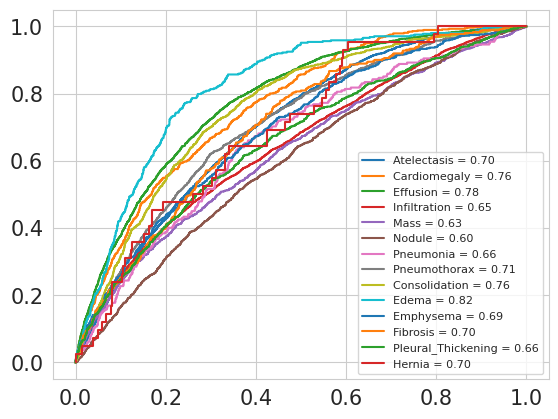

In [60]:
diseases = np.array(
    ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax',
     'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'])
for i in range(14):
    fpr, tpr, threshold = metrics.roc_curve(res[:,i], model_res[:,i], pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    print(diseases[i],f' Roc-Auc = {roc_auc}')
    plt.plot(fpr, tpr, label = f'{diseases[i]} = %0.2f' % roc_auc)
plt.legend(fontsize="8")

0.4648051619379385

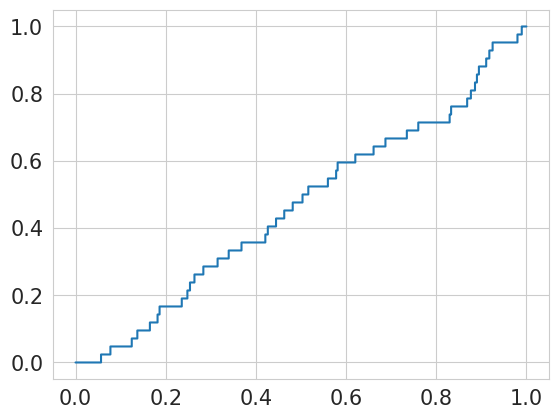

In [84]:
fpr, tpr, threshold = metrics.roc_curve(res[:,-1], model_res[:,-1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
roc_auc

In [83]:
model_res

array([[0.6911994 , 0.29661354, 0.7138909 , ..., 0.2210123 , 0.34795097,
        0.02884964],
       [0.68692595, 0.30193785, 0.708974  , ..., 0.22769767, 0.35210472,
        0.03228825],
       [0.6869453 , 0.3015452 , 0.7091138 , ..., 0.22721162, 0.35151243,
        0.03176104],
       ...,
       [0.68430537, 0.3033633 , 0.705943  , ..., 0.22972526, 0.35277444,
        0.03251196],
       [0.6885128 , 0.29942092, 0.71100795, ..., 0.22478159, 0.34980595,
        0.03025378],
       [0.6829342 , 0.30622151, 0.7044579 , ..., 0.23253758, 0.35501543,
        0.03456336]], dtype=float32)

In [82]:
model_res[:,1]

array([0.29661354, 0.30193785, 0.3015452 , ..., 0.3033633 , 0.29942092,
       0.30622151], dtype=float32)

In [69]:
multilabel_confusion_matrix(res, model_labels)

[[[    0 20013]
  [    0  2420]]

 [[21851     0]
  [  582     0]]

 [[    0 19679]
  [    0  2754]]

 [[    0 18495]
  [    0  3938]]

 [[21300     0]
  [ 1133     0]]

 [[    0 21098]
  [    0  1335]]

 [[22191     0]
  [  242     0]]

 [[21344     0]
  [ 1089     0]]

 [[21476     0]
  [  957     0]]

 [[22020     0]
  [  413     0]]

 [[21924     0]
  [  509     0]]

 [[22071     0]
  [  362     0]]

 [[21699     0]
  [  734     0]]

 [[22391     0]
  [   42     0]]]


In [86]:
print(classification_report(res[:,-1], model_labels[:,-1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22391
           1       0.00      0.00      0.00        42

    accuracy                           1.00     22433
   macro avg       0.50      0.50      0.50     22433
weighted avg       1.00      1.00      1.00     22433



In [ ]:
roc_auc_score(y_true_, y_prob)

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_true_, y_prob, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

### *ConvNet*

In [ ]:
class ConvNetPooling(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.convnext_base(pretrained=True)
        for param in self.model.parameters():
            param.require_grad = False
        self.model.avgpool = nn.AvgPool2d(3)
        #num_features = self.model.classifier[2].in_features # get number of in features of last layer
        self.model.classifier = nn.Sequential( nn.Flatten(), nn.Linear(102400, 14),
        nn.Sigmoid()) # replace model classifier

    def forward(self, x):
        return self.model(x)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.convnext_tiny(pretrained=True)
        for param in self.model.parameters():
            param.require_grad = False
        num_features = self.model.classifier[2].in_features # get number of in features of last layer
        self.model.classifier[2] = nn.Linear(num_features, 14)
        self.model.classifier.append(nn.Sigmoid())# replace model classifier

    def forward(self, x):
        return self.model(x)

In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet50(pretrained=True)
        for param in self.model.parameters():
            param.require_grad = False
        num_features = self.model.fc.in_features # get number of in features of last layer
        self.model.fc = nn.Sequential(nn.Linear(num_features, 14),nn.Sigmoid()) # replace model classifier

    def forward(self, x):
        return self.model(x)

In [ ]:
num_epoch = 12
model = ResNet().cuda()
model = torch.nn.DataParallel(model,device_ids=list(range(torch.cuda.device_count()))).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epoch)

In [ ]:
num_epoch = 12
model = ConvNet().cuda()
model = torch.nn.DataParallel(model,device_ids=list(range(torch.cuda.device_count()))).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epoch)

In [ ]:
base_model = train(model, optimizer, scheduler, calc_loss, train_dataloader, val_dataloader, num_epochs=num_epoch)
torch.save(base_model.state_dict(), 'convNet.pt')
torch.save(base_model.state_dict(), 'convNet_oneMore.pth')